Author: Angelika Vižintin

Main file of Image Depixelation Project

In [2]:
import os
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader

from architectures import CNN
from datasets import TrainingDataset, TestDataset
from utils import plot_loss

In [3]:
# Load training dataset
training_set = TrainingDataset("training")
# Load validation dataset (for validation set, 10 % of all folders from the given 'training' folder
# (namely the ones ending with '9') were moved to the folder 'validation'
validation_set = TrainingDataset("validation")
# Load test dataset
test_set = TestDataset("test_set.pkl")

In [5]:
torch.random.manual_seed(0)

# Create data loaders
batch_size = 32
num_workers = 2
dataloader_train = DataLoader(training_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
dataloader_eval = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
dataloader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
#define network
network = CNN(hidden_layers=5, kernels=32, kernel_size=3)    #CNN with 5 hidden layers with 32 kernels of size 3.

In [7]:
#Train the model

def training_loop(network: torch.nn.Module,
                  dataloader_train: torch.utils.data.DataLoader,
                  dataloader_eval: torch.utils.data.DataLoader,
                  num_epochs: int,
                  eval_epochs: int = 5,
                  learning_rate: float = 0.005,
                  save_path: str = "trained_model.pt"
                  ) -> tuple[list, list , list]:
    """ Function for training and validation of NN model for predicting pixel values in pixelated images.

    :param network: NN model
    :param dataloader_train: training dataset wrapped in DataLoader
    :param dataloader_eval: validation dataset wrapped in DataLoader
    :param num_epochs: number of training epochs
    :param eval_epochs: do evaluation after every eval_epochs
    :param learning_rate: hyperparameter learning rate
    :param save_path: file path where the trained model and lists containing training and evaluation loss will be saved
    :return: list of training losses, list of evaluation losses, list of epochs at which evaluation was performed.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network.to(device)  # Move the network to the device (CPU or GPU)

    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    # Load the saved model if it exists
    if os.path.exists(save_path):
        network.load_state_dict(torch.load(save_path))
        print("Loaded model from:", save_path)

    # Load the saved losses and epochs if they exist
    train_losses = []
    eval_losses = []
    eval_epochs_ls = []
    if os.path.exists("train_losses.pt"):
        train_losses = torch.load("train_losses.pt")
    if os.path.exists("eval_losses.pt"):
        eval_losses = torch.load("eval_losses.pt")
    if os.path.exists("eval_epochs.pt"):
        eval_epochs_ls = torch.load("eval_epochs.pt")

    # Training
    start_epoch = len(train_losses)  # Get the epoch to resume training from
    progress_bar = tqdm(total=num_epochs, desc="Overall Progress")
    for epoch in range(start_epoch, start_epoch + num_epochs):
        i = 0
        network.train()
        running_train_loss = 0.0
        for input_tensor, target_tensor, _ in dataloader_train:
            i += 1
            input_tensor = input_tensor.to(device)  # Move input tensor to the device
            target_tensor = target_tensor.to(device)  # Move target tensor to the device
            output = network(input_tensor)  # Get model output (forward pass)
            loss = F.mse_loss(output, target_tensor)  # Compute loss
            loss.backward()  # Compute gradients (backward pass)
            optimizer.step()  # Perform gradient descent update step
            optimizer.zero_grad()  # Reset gradients
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / i)

        # Evaluation
        if (epoch % eval_epochs) == 0:
            eval_epochs_ls.append(epoch)
            network.eval()
            running_val_loss = 0.0
            with torch.no_grad():  # Disable gradient computation
                for input_tensor, target_tensor, _ in dataloader_eval:
                    input_tensor = input_tensor.to(device)  # Move input tensor to the device
                    target_tensor = target_tensor.to(device)  # Move target tensor to the device
                    output = network(input_tensor)
                    loss = F.mse_loss(output, target_tensor)
                    running_val_loss += loss.item()
                eval_losses.append(running_val_loss)

        # Save the model after each epoch
        torch.save(network.state_dict(), save_path)

        # Update the overall progress bar
        progress_bar.update(1)

    # Save the updated losses and epochs
    torch.save(train_losses, "train_losses.pt")
    torch.save(eval_losses, "eval_losses.pt")
    torch.save(eval_epochs_ls, "eval_epochs.pt")

    progress_bar.close()

    return train_losses, eval_losses, eval_epochs_ls

Loaded model from: trained_model.pt


Overall Progress: 100%|██████████| 2/2 [19:41<00:00, 590.72s/it]


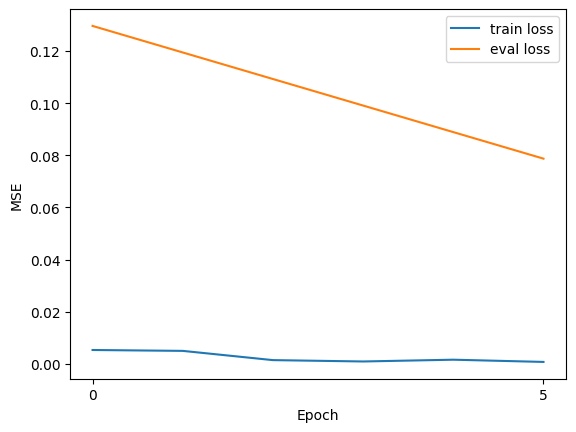

In [26]:
#Start or continue training and plot the losses
torch.random.manual_seed(0)
train_losses, eval_losses, eval_epochs = training_loop(network, dataloader_train, dataloader_eval, num_epochs=2)
plot_loss(train_losses, eval_losses, eval_epochs)

In [27]:
#make predictions for test dataset

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network.load_state_dict(torch.load("trained_model.pt"))
network.to(device)  # Move the model to the device (CPU or GPU)
network.eval()

predictions = []
with torch.no_grad():
    for inputs_tensor, _, _ in dataloader_test:
        inputs_tensor = inputs_tensor.to(device)  # Move input tensor to the device
        output = network(inputs_tensor)  # Get model predictions
        predictions.append(output)


In [28]:
# from the predicitons extract and flatten the pixelated areas of the images and put them into a list
predicted_areas = []
for i in range(test_set.__len__()):
    predicted_image = np.array(predictions[i]*255, dtype=np.uint8)
    predicted_image.resize((64,64))
    _, inputs, _ = test_set[i]
    known_array = np.array(inputs[1], dtype=bool)
    predicted_area =  predicted_image[~known_array]
    predicted_areas.append(predicted_area)

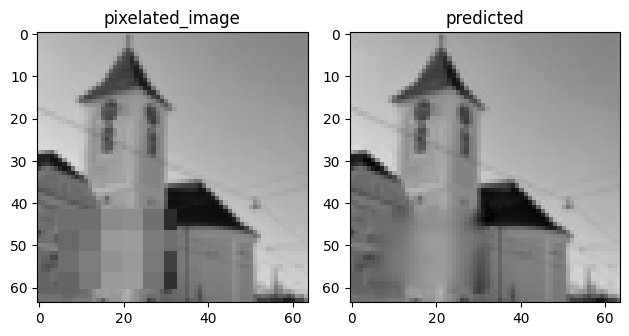

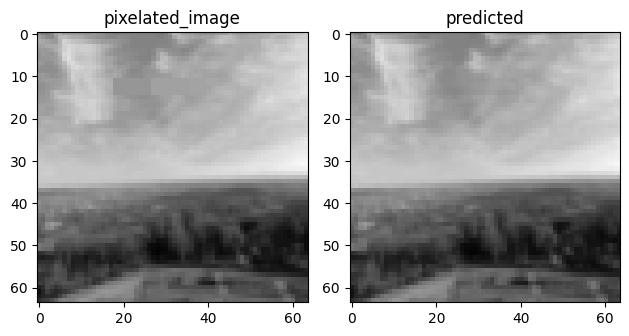

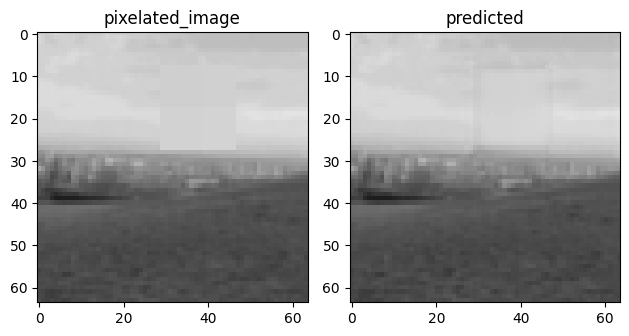

In [30]:
#visually inspect the predicted depixelated images
import matplotlib.pyplot as plt

for i in range(3):
    predicted_image = np.array(predictions[i]*255, dtype=np.uint8)
    predicted_image.resize((64,64))
    _, inputs, _ = test_set[i]
    known_array = np.array(inputs[1], dtype=bool)
    pixelated_image = inputs[0]*255

    fig, axes = plt.subplots(ncols=2)
    axes[0].imshow(pixelated_image, cmap="gray", vmin=0, vmax=255)
    axes[0].set_title("pixelated_image")
    axes[1].imshow(predicted_image, cmap="gray", vmin=0, vmax=255)
    axes[1].set_title("predicted")
    fig.tight_layout()
    plt.show()